In [1]:
import os
import glob
import random

import torch
import numpy as np
import cv2

import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision.transforms import v2
import torch.nn.functional as F

from IPython.display import Image

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device = torch.device("cuda")

In [3]:
def encode(a):
    idx = {}
    for ai in a:
        if ai not in idx:
            idx[ai] = len(idx)
    for i in range(len(a)):
        a[i] = idx[a[i]]
    del idx
    return a

In [4]:
current_directory = os.getcwd()
DATA_PATH = os.path.join(current_directory, "archive\Training\Training")
DATA_PATH_VAL = os.path.join(current_directory, "archive\Validation\Validation")
DATA_PATH_TEST = os.path.join(current_directory, "archive\Test\Test")

In [5]:
class SmokingDataset(Dataset):

    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.img_names = os.listdir(rootdir)
        random.shuffle(self.img_names)
        self.transform = transform
        self.img_paths = []
        self.img_labels = []

        for img in self.img_names:
            path = os.path.join(rootdir, img)
            label = img.split('_')[0]
            self.img_paths.append(path)
            self.img_labels.append(label)

        self.img_labels = encode(self.img_labels)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index) -> tuple:
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)

        if self.transform:
            image = self.transform(image=image)["image"]

        label = self.img_labels[index]

        return (image, label)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentation_transform = A.Compose([
    A.Flip(p=0.3),
    A.ElasticTransform(alpha=1.15, sigma=50, alpha_affine=10),
    A.Sharpen(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])
transform = A.Compose(
    [
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2()
    ]
)

In [7]:
batch_size = 64
dataset = SmokingDataset(DATA_PATH, augmentation_transform)
train_loader = DataLoader(dataset, batch_size=batch_size)
val_dataset = SmokingDataset(DATA_PATH_VAL, transform)
val_loader = DataLoader(val_dataset, batch_size=180)

In [8]:
class SmokingClassifier(nn.Module):
    def __init__(self):
        super(SmokingClassifier, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(16, 16, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(14400, 512)
        self.linear_2 = nn.Linear(512, 1)


    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        x = F.sigmoid(x)
        
        return torch.flatten(x)

In [9]:
class SmokingClassifier2(nn.Module):
    def __init__(self):
        super(SmokingClassifier2, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.bNorm_1 = nn.BatchNorm2d(16)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(16, 16, (3,3), 1)
        self.bNorm_2 = nn.BatchNorm2d(16)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(14400, 512)
        self.linear_2 = nn.Linear(512, 1)


    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.bNorm_1(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.bNorm_2(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        x = F.sigmoid(x)
        
        return torch.flatten(x)

In [29]:
model = SmokingClassifier()
model.to(device)
model2 = SmokingClassifier2()
model2.to(device)
loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001,)

In [30]:
def val(model, val_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in val_loader:
        y = y.to(device)
        pre = model(x.to(device))
        pred = torch.Tensor([1 if i>0.5 else 0 for i in pre])
        tp += int(torch.eq(torch.Tensor(pred),y.to('cpu')).sum())
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):

            y = y.type(torch.float32)
            (x, y) = (x.to(device), y.to(device))
            y_pred = model.forward(x)
            y_pred = y_pred.to(device)
            loss = loss_fn(y_pred, y)

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*batch_size
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, val_loader)
        print('accuracy', acc)


In [31]:
train(train_loader, model, loss_function, optimizer, 100)

loss = 0.71027672290802, samples = 64
accuracy 0.6611111111111111
loss = 0.5608476996421814, samples = 128
accuracy 0.7277777777777777
loss = 0.5315411686897278, samples = 192
accuracy 0.7555555555555555
loss = 0.5168238878250122, samples = 256
accuracy 0.7611111111111111
loss = 0.5283915996551514, samples = 320
accuracy 0.7388888888888889
loss = 0.509756326675415, samples = 384
accuracy 0.7388888888888889
loss = 0.530708909034729, samples = 448
accuracy 0.75
loss = 0.509034276008606, samples = 512
accuracy 0.7611111111111111
loss = 0.4785478115081787, samples = 576


KeyboardInterrupt: 

In [32]:
test_dataset = SmokingDataset(DATA_PATH_VAL, transform)
test_loader = DataLoader(test_dataset, batch_size=224)

In [33]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').detach().numpy()
    pre = model(x.to(device)).to('cpu').detach().numpy()
    pred = [1 if i>0.5 else 0 for i in pre]
    predicts.append(pred)
    labels.append(y)

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
print(*labels, *predicts)
print(sum(*labels))
print(sum(*predicts))

[0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0
 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0
 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0
 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1
 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0] [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
90
84


In [36]:
cm = confusion_matrix(*labels, *predicts, labels=[1,0])
tn, fp, fn, tp = cm.ravel()

In [37]:
cm

array([[66, 24],
       [18, 72]], dtype=int64)

In [38]:
precision = tp/(tp+tn)
recall = tp/(tp+fn)
accuracy = tp/(tp+fp)
print("Precision: %.2f\nRecall: %.2f\nAccuracy: %.2f" % (precision,recall,accuracy))

Precision: 0.52
Recall: 0.80
Accuracy: 0.75


In [41]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

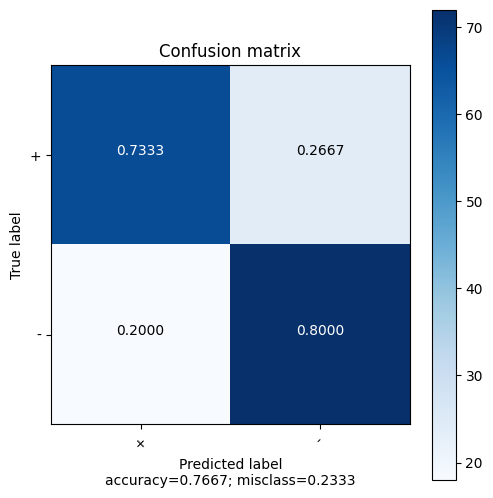

In [42]:
plot_confusion_matrix(cm, ('+', '-'))

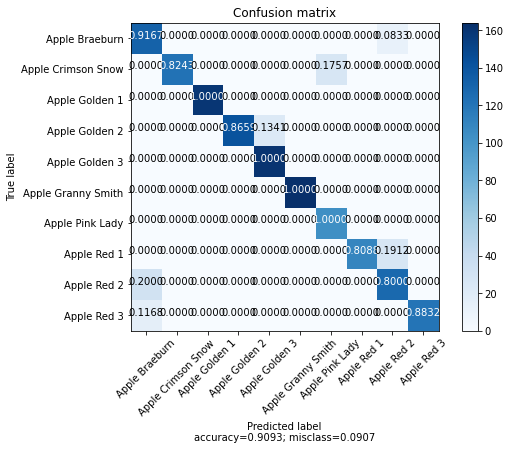

In [ ]:
plot_confusion_matrix(cm[:10,:10], tuple(classes.values())[:10])

<Figure size 14400x14400 with 0 Axes>

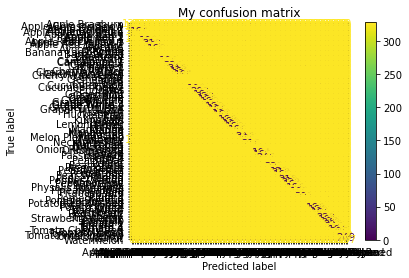

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(200,200))
cm = confusion_matrix(labels, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuple(classes.values()))
disp.plot()
plt.title("My confusion matrix")
plt.show()